 # Introduction
This report goes through a global database of power plants in order to create a general survey of the current capacity of the world to produce electricity. The data will be prepared, analyzed and plotted so we can then attempt to reach sensible conclusions about our findings.

Some of the things we will look at are:
- Total capacity to generate electricity
- Fuel types
- Power generation trends
- Countries and their preffered type of power plants

## Project scoping
The following four paragraphs will serve as an outline for the rest of the report, as well as a guide for the project's process and progress.

### Project goals
This project has the goal of creating an overview of how the world produces its electricity. We want to understand how and how much electrical power is being produced and look for any trends in regards to fuels and technologies being used, as well as how these are distributed among the world population.

Therefore we are going to use the data to answer a few questions:
- How many categories of technologies are being used to generate electricity in power plants?
- Are there any trends in the type of power plants being build and used?
- Which are the top producers of electricity and what fuels are they using?
- What countries have the most electricity generation capacity per capita?

### Data
The project will use two datasets in `.csv` format that contain data about power plants around the globe, as well as data about the population of countries. The two datasets are:
- Global Power Plants Database v1.3.0: [World Resources Institute](https://datasets.wri.org/dataset/globalpowerplantdatabase)
- Country Population Data: [United Nations World Population Prospect](https://population.un.org/wpp/Download/Standard/Population/)

### Analysis
Through the use of descriptive statistics and data visualization techniques, in this section we will transform and analyze the data in order to find the answer to our questions.

### Results
This will be the final section of the report, where based on our data exploration and analysis we will draw conclusions and check if we were able to find satisfying answers to our initial questions.

## Setting up the environment
**Import modules** - In this code block we will import the modules that will be used for the project.

In [82]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

**Set Graph Style** - Here we define custom settings for the visualizations in the report.

In [83]:
sns.set_style('darkgrid', {'markers':'o'})

# Data

## Loading the data
The datasets will be imported as separate `Pandas Dataframes` so we can use Python to analyze them.

**global_power_plant_database.csv** - The Global Power Plant Database is an open-source open-access dataset of grid-scale (1 MW and greater) electricity generating facilities operating across the world.

Although the database also contains data about how much electricity has actually been generated by each of them, as well as estimates where data is missing, we will only import the columns we are interested in analyzing.

- `country_long` (text): longer form of the country designation
- `name` (text): name or title of the power plant, generally in Romanized form
- `capacity_mw` (number): electrical generating capacity in megawatts
- `primary_fuel` (text): energy source used in primary electricity generation or export
- `commissioning_year` (number): year of plant operation, weighted by unit-capacity when data is available
- `year_of_capacity_data` (number): year the capacity information was reported

The columns commissioning_year and year_of_capacity_data contain values that do not represent whole years. They will be reformatted to remove any data that does not represent an year but the datatype will be kept as float in order to preserve `np.nan` values and compatibility with plotting modules.

In [84]:
gpp = pd.read_csv('./datasets/gppdb/global_power_plant_database.csv',\
    usecols=lambda x: x in ['country_long','capacity_mw','primary_fuel','commissioning_year','year_of_capacity_data'],\
    low_memory=False)

gpp.commissioning_year = gpp.commissioning_year.apply(lambda x: x if str(x).isalpha() else (int(str(x).strip().split('.')[0])))
gpp.year_of_capacity_data = gpp.year_of_capacity_data.apply(lambda x: x if str(x).isalpha() else (int(str(x).strip().split('.')[0])))

gpp.head()

,country_long,capacity_mw,primary_fuel,commissioning_year,year_of_capacity_data
0,Afghanistan,33.0,Hydro,NaN,2017.0
1,Afghanistan,10.0,Solar,NaN,NaN
2,Afghanistan,10.0,Solar,NaN,NaN
3,Afghanistan,66.0,Hydro,NaN,2017.0
4,Afghanistan,100.0,Hydro,NaN,2017.0


**WPP_TOTAL_POPULATION_BOTH_SEXES.csv**
- `Country` (text): long form country/region designation
- `2020` (number): Total Population - Both Sexes. De facto population in a country/region as of 1 July of the year indicated. Figures are presented in thousands.

The population has a space separator for thousands, which turns the data from the column into strings instead of integers. We will reformat the columns to remove it.

In [85]:
wpop = pd.read_csv('./datasets/WPP_TOTAL_POPULATION_BOTH_SEXES.csv',\
    usecols=lambda x: x in ['Country','2020'])
wpop.columns = ['country','population']

wpop['population'] = wpop['population'].apply(lambda x: int(x.strip().replace(' ','')))

wpop.head()

,country,population
0,Afghanistan,38928
1,Albania,2878
2,Algeria,43851
3,American Samoa,55
4,Andorra,77


## Data Exploration

### **gpp** dataset
We can begin by checking the shape of the dataset. It contains **34,936 rows** and **5 columns**.

Our dataset contains information about power plants in **167 countries**.

The dataset also contains **15 types of fuel** used by the power plants as a primary fuel. We chose to focus only on this variable for the moment because they are the most representative for each power plant, and the secondary types are closely related to it.

In [86]:
print('gpp shape:', gpp.shape)
print(gpp.columns)

gpp shape: (34936, 5)
Index(['country_long', 'capacity_mw', 'primary_fuel', 'commissioning_year',
       'year_of_capacity_data'],
      dtype='object')


In [87]:
print('Number of unique countries:',gpp.country_long.nunique())
print('Number of unique primary fuels:',gpp.primary_fuel.nunique())
print('Total capacity MW:',gpp.capacity_mw.sum())

Number of unique countries: 167
Number of unique primary fuels: 15
Total capacity MW: 5706975.447256999


In [88]:
gpp.describe()

,capacity_mw,commissioning_year,year_of_capacity_data
count,34936.000000,17447.000000,14887.000000
mean,163.355148,1997.356852,2018.218849
std,489.636072,23.436092,1.606428
min,1.000000,1896.000000,2000.000000
25%,4.900000,1988.000000,2017.000000
50%,16.745000,2007.000000,2019.000000
75%,75.344250,2014.000000,2019.000000
max,22500.000000,2020.000000,2019.000000


The `capacity_mw` of the Power Plants ranges from our minimum limit of 1 MW to over 22,500 MW, but straight away we can see that this is most likely an outlier.

When we graph the raw data, we can see that it is unimodal, heavily skewed to the right, with most observations to the left of the mean.

Another aspect that stands out is that while we have Power Plants that have been commissioned as early as 1896, the production capacity of plants only goes as far back as the year 2000. Even so, over 50% of the data in the `year_of_capacity_data` is from 2019 and 2020, which makes an accurate tracking of how Power Plant capacity has changed over time very unlikely.

In fact, only about half of the plants even have a `commissioning_year` reported. Although we do not have a suitable replacement for the missing data, we can still use these as possible indicators of how regulated and transparent Power Plants regulation is in certain jurisdictions.

The commissioning_year data is also unimodal, but heavily skewed to the right, with most observations falling to the right of the mean.

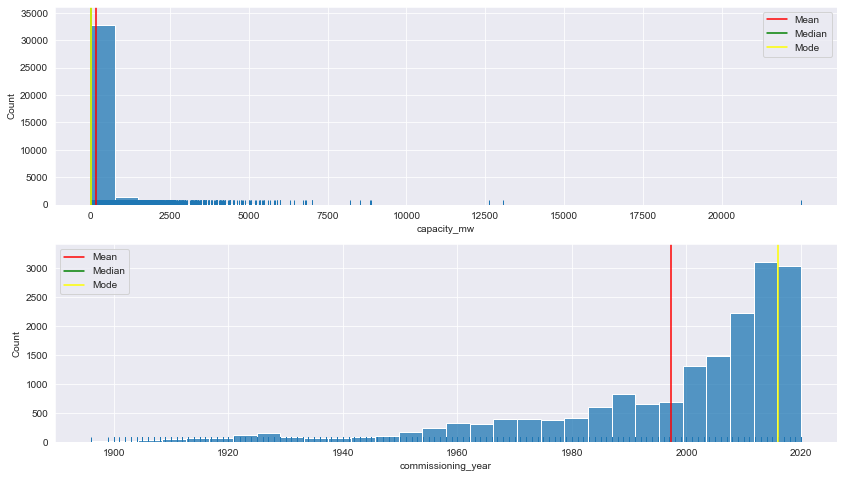

In [89]:
plt.figure(figsize=(14,8))
ax1 = plt.subplot(2,1,1)
sns.histplot(data=gpp, x='capacity_mw', bins=30)
ax1.set_xticks(range(0,22500,2500))
sns.rugplot(data=gpp, x='capacity_mw')
plt.axvline(x=np.mean(gpp.capacity_mw), color='red', label='Mean')
plt.axvline(x=np.median(gpp.capacity_mw), color='green', label='Median')
plt.axvline(x=stats.mode(gpp.capacity_mw)[0], color='yellow', label='Mode')
plt.legend()

ax2 = plt.subplot(2,1,2)
sns.histplot(data=gpp, x='commissioning_year', bins=30)
sns.rugplot(data=gpp, x='commissioning_year')
plt.axvline(x=np.mean(gpp.commissioning_year), color='red', label='Mean')
plt.axvline(x=np.median(gpp.commissioning_year), color='green', label='Median')
plt.axvline(x=stats.mode(gpp.commissioning_year)[0], color='yellow', label='Mode')

plt.legend()
plt.show()

### **wpop** dataframe

The dataset has **235 rows** and **2 columns**. Each row represents a country or region.

The population data is heavily right skewed, with a few outliers having close to 1.5 billion people.

The original dataset contains observations for more years, but we selected only the population in the year 2020 because we are only interested to make analyses on the current world population.

In [90]:
print('wpop shape:', wpop.shape)
print('Number of unique countries:',wpop.country.nunique())

wpop shape: (235, 2)
Number of unique countries: 235


In [91]:
wpop.describe()

,population
count,2.350000e+02
mean,3.316937e+04
std,1.351374e+05
min,1.000000e+00
25%,3.990000e+02
50%,5.460000e+03
75%,2.057700e+04
max,1.439324e+06


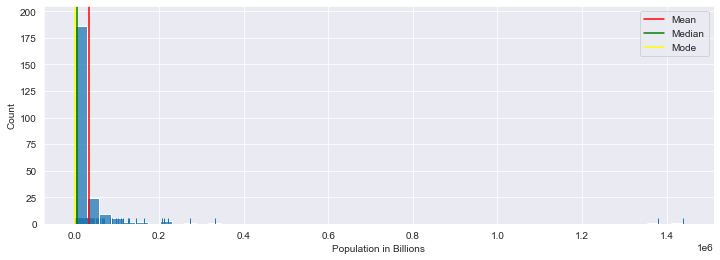

In [92]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot()
sns.histplot(data=wpop, x='population', bins=50)
sns.rugplot(data=wpop, x='population')
plt.xlabel('Population in Billions')
plt.axvline(x=np.mean(wpop.population), color='red', label='Mean')
plt.axvline(x=np.median(wpop.population), color='green', label='Median')
plt.axvline(x=stats.mode(wpop.population)[0], color='yellow', label='Mode')
plt.legend()
plt.show()

# Analysis

## Fuel types
In the exploration we found out there are 15 types of fuels being used by Power Plants. Now we would like to know more about their distribution.

We will create separate columns to record the number of power plants by fuel, total electricity capacity and average capacity.

In [93]:
primary_fuel = pd.DataFrame(gpp.primary_fuel.unique(), columns=['fuel'])
primary_fuel['count_pp'] = [gpp.primary_fuel[gpp.primary_fuel == x].count() for x in primary_fuel.fuel]
primary_fuel['capacity_mw'] = [gpp.capacity_mw[gpp.primary_fuel == x].sum() for x in primary_fuel.fuel]
primary_fuel['avg_capacity_mw'] = [gpp.capacity_mw[gpp.primary_fuel == x].mean() for x in primary_fuel.fuel]

primary_fuel.sort_values(by=['avg_capacity_mw'], ascending=False, inplace=True, ignore_index=True)

primary_fuel

,fuel,count_pp,capacity_mw,avg_capacity_mw
0,Nuclear,195,4.079118e+05,2091.855179
1,Coal,2330,1.965541e+06,843.579828
2,Gas,3998,1.493051e+06,373.449375
3,Petcoke,12,2.424577e+03,202.048125
4,Hydro,7156,1.053160e+06,147.171551
5,Oil,2320,2.618787e+05,112.878754
6,Cogeneration,41,4.048000e+03,98.731707
7,Other,43,3.612860e+03,84.020000
8,Geothermal,189,1.268775e+04,67.130952
9,Wave and Tidal,10,5.522000e+02,55.220000


The table contains the counts of power plants by their primary fuel. Most power plants are Solar, Hydro and Wind plants. This points is also illustrated in the graph below.

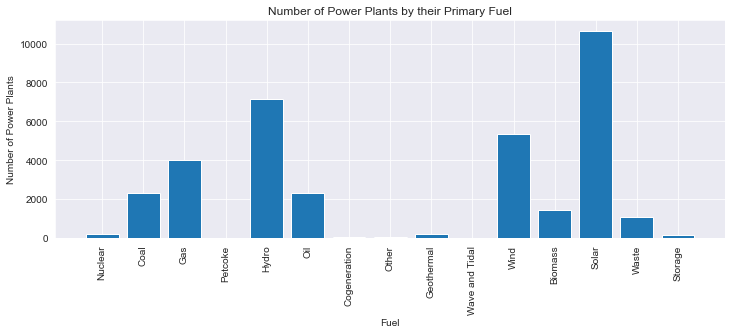

In [94]:
plt.figure(figsize=(12,4))
ax = plt.subplot()
plt.bar(x=range(len(primary_fuel.fuel)), height=primary_fuel.count_pp)
ax.set_xticks(range(len(primary_fuel)))
ax.set_xticklabels(primary_fuel.fuel)
plt.xlabel('Fuel')
plt.xticks(rotation=90)
plt.ylabel('Number of Power Plants')
plt.title('Number of Power Plants by their Primary Fuel')
plt.show()

But do they also have the greatest capacity to generate electricity?
So when it comes to their total capacity, Coal and Gas take the first spots, followed by Hydro.

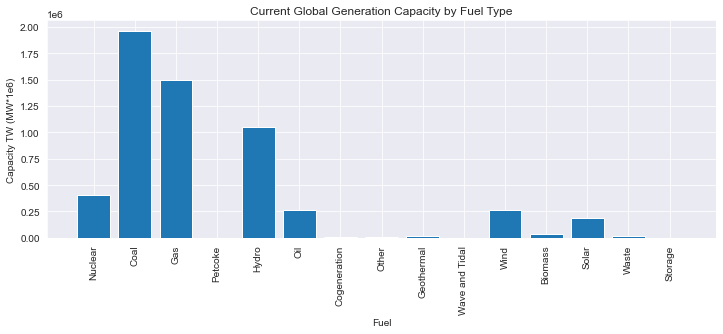

In [115]:
plt.figure(figsize=(12,4))
ax = plt.subplot()
plt.bar(x=range(len(primary_fuel.fuel)), height=primary_fuel.capacity_mw)
plt.title('Current Global Generation Capacity by Fuel Type')
plt.xlabel('Fuel')
plt.ylabel('Capacity TW (MW*1e6)')
ax.set_xticks(range(len(primary_fuel.fuel)))
ax.set_xticklabels(primary_fuel.fuel, rotation=90)
plt.show()

When we look at the current global capacity to generate electricity, we see that the types enumerated earlier, although more numerous, still have a long way to go in order to compete with Coal and Gas.

This also indicates that Solar, Hydro and Wind are on average much smaller than Coal and Gas plants. And when we look at the average capacity of power plants by fuel, it is indeed confirmed. Coal, Gas and Oil rank in the top 6, but Hydro also manages to have a high capacity

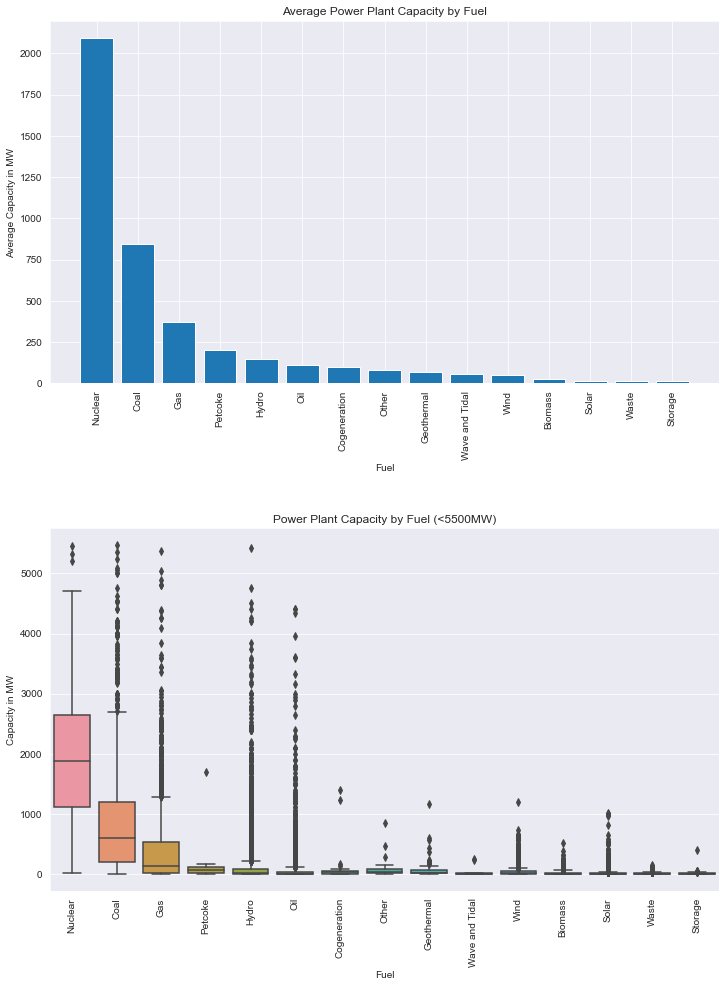

In [96]:
plt.figure(figsize=(12,16))
ax1 = plt.subplot(2,1,1)
plt.bar(x=range(len(primary_fuel.fuel)), height=primary_fuel.avg_capacity_mw)
plt.title('Average Power Plant Capacity by Fuel')
plt.xlabel('Fuel')
plt.xticks(rotation=90)
plt.ylabel('Average Capacity in MW')
ax1.set_xticks(range(len(primary_fuel)))
ax1.set_xticklabels(primary_fuel.fuel)

ax2 = plt.subplot(2,1,2)
sns.boxplot(data=gpp[gpp.capacity_mw < 5500], x='primary_fuel', y='capacity_mw', order=primary_fuel.fuel)
plt.xticks(rotation=90)
plt.title('Power Plant Capacity by Fuel (<5500MW)')
plt.xlabel('Fuel')
plt.ylabel('Capacity in MW')

plt.subplots_adjust(hspace=0.4)
plt.show()

When we look at the average plant capacity, it looks like power plants who use a Nuclear type of fuel, have a far greater capacity.

But when we look back to the rest of the data, we see that it is still far behind many other types in terms of adoption.

## Power Trends
Have there been any trends in the technologies being used to build new power plants throughout the years?

In [97]:
power_trend = gpp.groupby(by=['primary_fuel','commissioning_year']).country_long.count().reset_index()

power_trend = power_trend.pivot(index='commissioning_year',columns='primary_fuel', values='country_long')
power_trend.columns = ['Biomass','Coal','Cogeneration','Gas','Geothermal','Hydro','Nuclear','Oil','Other','Petcoke','Solar','Storage','Waste','Wind']

power_trend


,Biomass,Coal,Cogeneration,Gas,Geothermal,Hydro,Nuclear,Oil,Other,Petcoke,Solar,Storage,Waste,Wind
commissioning_year,,,,,,,,,,,,,,
1896.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1899.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900.0,NaN,NaN,NaN,1.0,NaN,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
1901.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1902.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016.0,8.0,84.0,1.0,45.0,NaN,45.0,NaN,38.0,NaN,NaN,464.0,11.0,15.0,169.0
2017.0,3.0,46.0,NaN,48.0,2.0,22.0,NaN,5.0,1.0,NaN,523.0,19.0,8.0,105.0
2018.0,3.0,14.0,NaN,52.0,2.0,4.0,NaN,7.0,1.0,NaN,480.0,10.0,4.0,40.0


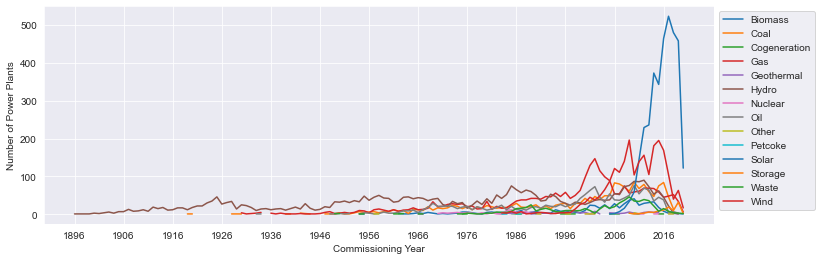

In [98]:
ax=power_trend.plot(kind='line',figsize=(12,4))
plt.legend(bbox_to_anchor=(1, 1))
ax.set_xticks(range(1896,2021,10))
plt.xlabel('Commissioning Year')
plt.ylabel('Number of Power Plants')
plt.show()

We can see in this plot that Solar has picked up a lot in the last 10 years, but the commissioning of new plants plummeted in 2020. For the rest of fuels, we can see an overal upward trend as well, but they also have seen a decline during the last few years.

### Renewable Fuels Power Plants
We want to analyze the data base on whether they are running on **Renewable** power sources (geothermal, hydro, wind, solar, biomass, waste, wave and tidal) or not.

In [99]:
renewables = ['Solar','Wind','Biomass','Wave and Tidal','Geothermal','Hydro','Waste']
gpp['is_renewable'] = gpp.primary_fuel.isin(renewables)

gpp[gpp.is_renewable].head()

,country_long,capacity_mw,primary_fuel,commissioning_year,year_of_capacity_data,is_renewable
0,Afghanistan,33.0,Hydro,NaN,2017.0,True
1,Afghanistan,10.0,Solar,NaN,NaN,True
2,Afghanistan,10.0,Solar,NaN,NaN,True
3,Afghanistan,66.0,Hydro,NaN,2017.0,True
4,Afghanistan,100.0,Hydro,NaN,2017.0,True


In [100]:
renewable_fuel = pd.DataFrame(gpp.is_renewable.unique(), columns=['is_renewable'])
renewable_fuel['count_pp'] = [gpp.primary_fuel[gpp.is_renewable == x].count() for x in renewable_fuel.is_renewable]
renewable_fuel['capacity_mw'] = [gpp.capacity_mw[gpp.is_renewable == x].sum() for x in renewable_fuel.is_renewable]
renewable_fuel['avg_capacity_mw'] = [gpp.capacity_mw[gpp.is_renewable == x].mean() for x in renewable_fuel.is_renewable]

renewable_fuel

,is_renewable,count_pp,capacity_mw,avg_capacity_mw
0,True,25862,1.566796e+06,60.582926
1,False,9074,4.140180e+06,456.268438


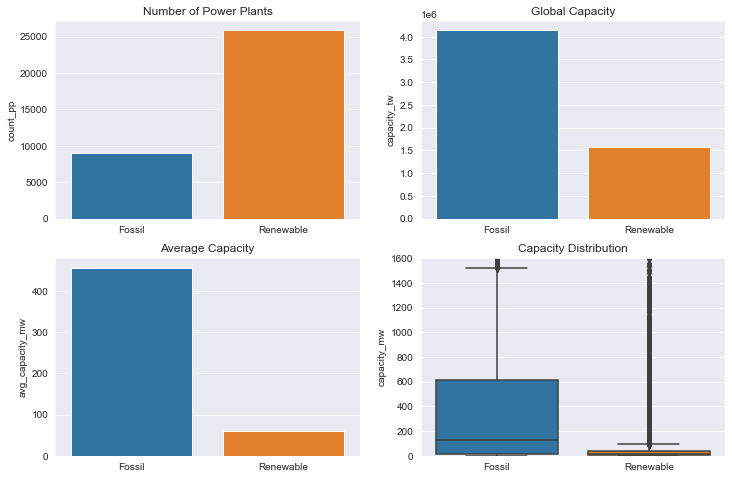

In [116]:
plt.figure(figsize=(12,8))
labels = ['Fossil','Renewable']

ax1 = plt.subplot(2,2,1)
sns.barplot(data=renewable_fuel, x='is_renewable', y='count_pp')
ax1.set_xticklabels(labels)
plt.xlabel(None)
plt.title('Number of Power Plants')

ax2 = plt.subplot(2,2,2)
sns.barplot(data=renewable_fuel, x='is_renewable', y='capacity_mw')
ax2.set_xticklabels(labels)
plt.xlabel(None)
plt.ylabel('capacity_tw')
plt.title('Global Capacity')

ax3 = plt.subplot(2,2,3)
sns.barplot(data=renewable_fuel, x='is_renewable', y='avg_capacity_mw')
ax3.set_xticklabels(labels)
plt.xlabel(None)
plt.title('Average Capacity')

ax4 = plt.subplot(2,2,4)
sns.boxplot(data=gpp, x='is_renewable', y='capacity_mw')
plt.axis([-0.5,1.5,0,1600])
ax4.set_xticklabels(labels)
plt.xlabel(None)
plt.title('Capacity Distribution')

plt.show()

The power plants that run on Renewable primary fuels, although much more numerous, generally have a much smaller capacity to produce electricity, and they also make up a considerably lower proportion of the global capacity.

In [102]:
renewable_trend = gpp.groupby(by=['is_renewable','commissioning_year']).country_long.count().reset_index()

renewable_trend = renewable_trend.pivot(index='commissioning_year',columns='is_renewable', values='country_long')
renewable_trend.columns = ['Fossil','Renewable']

renewable_trend

,Fossil,Renewable
commissioning_year,,
1896.0,NaN,1.0
1899.0,NaN,1.0
1900.0,3.0,3.0
1901.0,NaN,2.0
1902.0,NaN,4.0
...,...,...
2016.0,179.0,701.0
2017.0,119.0,663.0
2018.0,84.0,533.0


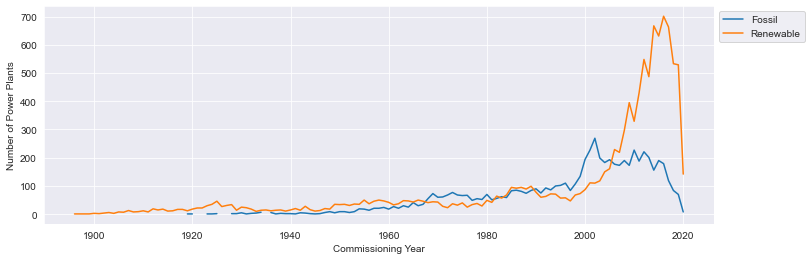

In [103]:
renewable_trend.plot(kind='line', figsize=(12,4))
plt.legend(bbox_to_anchor=(1, 1))
ax.set_xticks(range(1896,2021,10))
plt.xlabel('Commissioning Year')
plt.ylabel('Number of Power Plants')
plt.show()

Renewables started off as being the more popular option of creating electricity thanks to Hydro power, but it was slowly taken over by Fossil power plants in the second half of the 20th century.

However, renewables are yet again becoming the most popular choice, surpassing fossil plants in the second half of the 2000s. But unlinke the last time, this is no longer a tight race, as we can also observe a declining trend for fossil fuels, which had their peak in the early 2000s.

## Countries and Power Plants
Now that we have looked at power plants from a global perspective, we can start bringing the data into the context of countries and their population.

In [104]:
country_fuel = gpp.groupby(by=['country_long','is_renewable'])\
    .capacity_mw.agg(['count','sum','mean'])\
    .reset_index()
country_fuel.columns = ['country_long','is_renewable','count_pp','capacity_mw','avg_capacity_mw']
country_fuel

,country_long,is_renewable,count_pp,capacity_mw,avg_capacity_mw
0,Afghanistan,False,1,42.000,42.000000
1,Afghanistan,True,8,258.550,32.318750
2,Albania,False,1,98.000,98.000000
3,Albania,True,7,1431.000,204.428571
4,Algeria,False,31,15179.000,489.645161
...,...,...,...,...,...
300,Yemen,False,7,1045.000,149.285714
301,Zambia,False,8,469.600,58.700000
302,Zambia,True,7,2219.737,317.105286
303,Zimbabwe,False,1,920.000,920.000000


Because we are dealing with a very large number of countries, we will order and analyze the top ten countries based on:
- Largest `count_pp`
- Most `Renewable` plants
- Most `Fossil` pants

### Top Power Plants

In [105]:
cpp = country_fuel.pivot(index='country_long',columns='is_renewable', values='count_pp').reset_index()
cpp.columns = ['country_long','Fossil','Renewable']
cpp['count_pp'] = cpp.Fossil + cpp.Renewable
cpp_count_pp = cpp.sort_values(by='count_pp', ascending=False, inplace=True, ignore_index=True)
cpp_count_pp = cpp.head(10)

cpp_count_pp

,country_long,Fossil,Renewable,count_pp
0,United States of America,3203.0,6630.0,9833.0
1,China,1133.0,3102.0,4235.0
2,United Kingdom,120.0,2631.0,2751.0
3,Brazil,767.0,1593.0,2360.0
4,France,38.0,2117.0,2155.0
5,India,347.0,1242.0,1589.0
6,Germany,318.0,991.0,1309.0
7,Canada,107.0,1052.0,1159.0
8,Spain,104.0,725.0,829.0
9,Russia,374.0,171.0,545.0


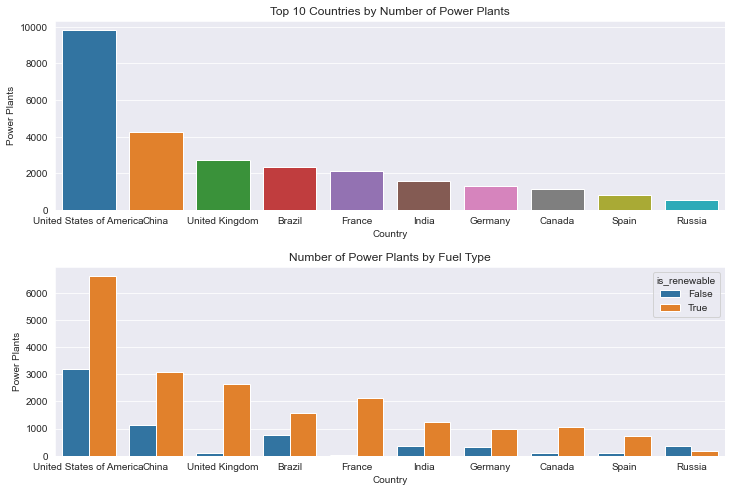

In [106]:
plt.figure(figsize=(12,8))
ax1 = plt.subplot(2,1,1)
sns.barplot(data=cpp_count_pp, x='country_long', y='count_pp')
plt.title('Top 10 Countries by Number of Power Plants')
plt.xlabel('Country')
plt.ylabel('Power Plants')

ax2 = plt.subplot(2,1,2)
sns.barplot(data=country_fuel[country_fuel.country_long.isin(cpp_count_pp.country_long)],\
    x='country_long', y='count_pp',\
    hue='is_renewable', order=cpp_count_pp.country_long)
plt.title('Number of Power Plants by Fuel Type')
plt.xlabel('Country')
plt.ylabel('Power Plants')

plt.subplots_adjust(hspace=0.3)
plt.show()

Except for Russia, the top 9 countries by the number of power plants, all have more power plants running on renewable fuels.

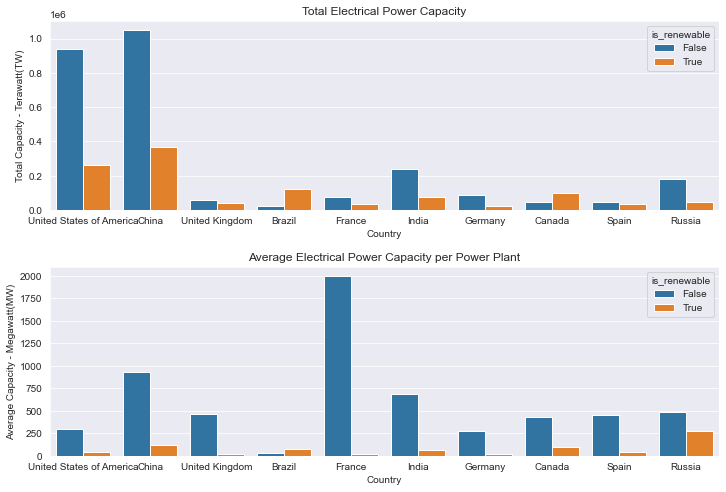

In [107]:
plt.figure(figsize=(12,8))
ax1 = plt.subplot(2,1,1)
sns.barplot(data=country_fuel[country_fuel.country_long.isin(cpp_count_pp.country_long)],\
    x='country_long', y='capacity_mw',\
    hue='is_renewable', order=cpp_count_pp.country_long)
plt.title('Total Electrical Power Capacity')
plt.xlabel('Country')
plt.ylabel('Total Capacity - Terawatt(TW)')

ax2 = plt.subplot(2,1,2)
sns.barplot(data=country_fuel[country_fuel.country_long.isin(cpp_count_pp.country_long)],\
    x='country_long', y='avg_capacity_mw',\
    hue='is_renewable', order=cpp_count_pp.country_long)
plt.title('Average Electrical Power Capacity per Power Plant')
plt.xlabel('Country')
plt.ylabel('Average Capacity - Megawatt(MW)')

plt.subplots_adjust(hspace=0.3)
plt.show()

Despite having more power plants that run on renewable fuels, most coutries still have the majority of their electrical capacity generated by fossil fuels.

Notable exceptions are Brazil and Canada, whos capacities come mostly from power plants running on renewable fuels.

### TPP - Renewables

In [108]:
cpp_renewables = cpp.sort_values(by='Renewable', ascending=False, ignore_index=True)
cpp_renewables = cpp_renewables.head(10)
cpp_renewables

,country_long,Fossil,Renewable,count_pp
0,United States of America,3203.0,6630.0,9833.0
1,China,1133.0,3102.0,4235.0
2,United Kingdom,120.0,2631.0,2751.0
3,France,38.0,2117.0,2155.0
4,Brazil,767.0,1593.0,2360.0
5,India,347.0,1242.0,1589.0
6,Canada,107.0,1052.0,1159.0
7,Germany,318.0,991.0,1309.0
8,Spain,104.0,725.0,829.0
9,Portugal,6.0,463.0,469.0


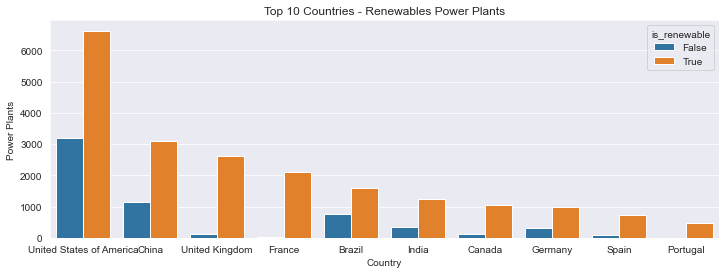

In [109]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot()
sns.barplot(data=country_fuel[country_fuel.country_long.isin(cpp_renewables.country_long)],\
    x='country_long', y='count_pp',\
    hue='is_renewable', order=cpp_renewables.country_long)
plt.title('Top 10 Countries - Renewables Power Plants')
plt.xlabel('Country')
plt.ylabel('Power Plants')
plt.show()

### TPP - Fossils

In [110]:
cpp_fossil = cpp.sort_values(by='Fossil', ascending=False, ignore_index=True)
cpp_fossil = cpp_fossil.head(10)
cpp_fossil

,country_long,Fossil,Renewable,count_pp
0,United States of America,3203.0,6630.0,9833.0
1,China,1133.0,3102.0,4235.0
2,Brazil,767.0,1593.0,2360.0
3,Russia,374.0,171.0,545.0
4,India,347.0,1242.0,1589.0
5,Germany,318.0,991.0,1309.0
6,Australia,204.0,282.0,486.0
7,Argentina,167.0,69.0,236.0
8,Indonesia,127.0,51.0,178.0
9,Japan,122.0,400.0,522.0


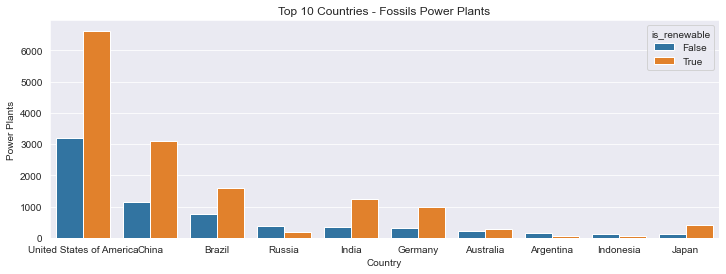

In [111]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot()
sns.barplot(data=country_fuel[country_fuel.country_long.isin(cpp_fossil.country_long)],\
    x='country_long', y='count_pp',\
    hue='is_renewable', order=cpp_fossil.country_long)
plt.title('Top 10 Countries - Fossils Power Plants')
plt.xlabel('Country')
plt.ylabel('Power Plants')
plt.show()

## Electrical Capacity per Capita

In order to calculate how much electricity a country has the capacity for per capita, we will merge the `ccountry_fuel` and the `wpop` datasets using an inner merge as we can only perform this analysis on countries that we have a population for.

In [112]:
cf_wpop = country_fuel.merge(right=wpop, left_on='country_long', right_on='country')
cf_wpop.drop(columns='country', inplace=True)
cf_wpop['capacity_per_1k'] = cf_wpop.capacity_mw / cf_wpop.population
cf_wpop['plant_per_1k'] = cf_wpop.count_pp / cf_wpop.population
cf_wpop.head()

,country_long,is_renewable,count_pp,capacity_mw,avg_capacity_mw,population,capacity_per_1k,plant_per_1k
0,Afghanistan,False,1,42.00,42.000000,38928,0.001079,0.000026
1,Afghanistan,True,8,258.55,32.318750,38928,0.006642,0.000206
2,Albania,False,1,98.00,98.000000,2878,0.034051,0.000347
3,Albania,True,7,1431.00,204.428571,2878,0.497220,0.002432
4,Algeria,False,31,15179.00,489.645161,43851,0.346149,0.000707


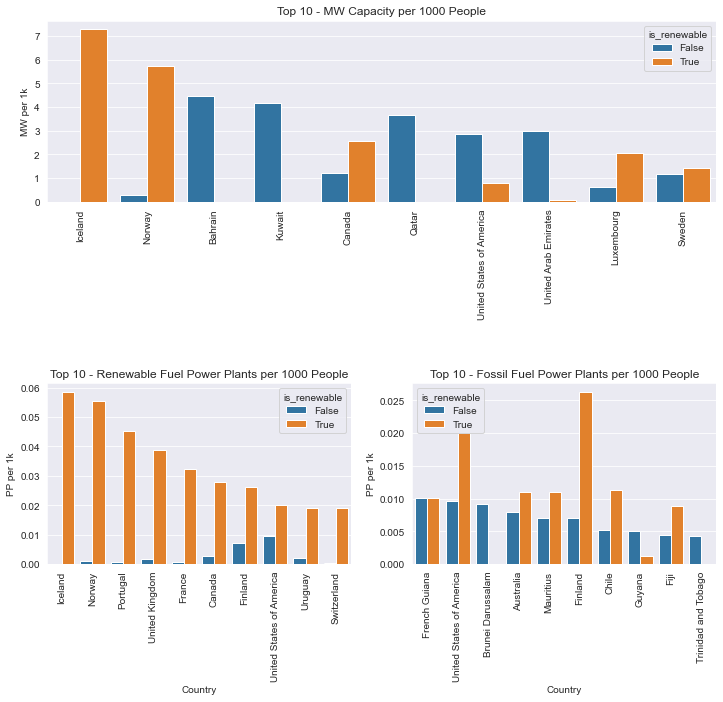

In [113]:
order_capacity = cf_wpop.groupby(by='country_long').capacity_per_1k.sum().reset_index()\
    .sort_values(by='capacity_per_1k', ascending=False, ignore_index=True)\
    .head(10).country_long
order_plant_renewable = cf_wpop[cf_wpop.is_renewable == True].sort_values(by=('plant_per_1k'), ascending=False)\
    .head(10).country_long
order_plant_fossil = cf_wpop[cf_wpop.is_renewable == False].sort_values(by=('plant_per_1k'), ascending=False)\
    .head(10).country_long

plt.figure(figsize=(12,10))
ax1 = plt.subplot(2,1,1)
sns.barplot(data=cf_wpop[cf_wpop.country_long.isin(order_capacity)],\
    x='country_long', y='capacity_per_1k', hue='is_renewable',\
    order=order_capacity)
plt.xticks(rotation=90)
plt.title('Top 10 - MW Capacity per 1000 People')
plt.xlabel(None)
plt.ylabel('MW per 1k')

ax2 = plt.subplot(2,2,3)
sns.barplot(data=cf_wpop[cf_wpop.country_long.isin(order_plant_renewable)],\
    x='country_long', y='plant_per_1k', hue='is_renewable',\
    order=order_plant_renewable)
plt.title('Top 10 - Renewable Fuel Power Plants per 1000 People')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('PP per 1k')

ax3 = plt.subplot(2,2,4)
sns.barplot(data=cf_wpop[cf_wpop.country_long.isin(order_plant_fossil)],\
    x='country_long', y='plant_per_1k', hue='is_renewable',\
    order=order_plant_fossil)
plt.title('Top 10 - Fossil Fuel Power Plants per 1000 People')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('PP per 1k')

plt.subplots_adjust(hspace=1)
plt.show()

We can see in the graphs above which are the countries with the most electricity generation capacity per 1000 people.

Iceland is the country that ranks first for two of our tops, having the greatest capacity and the most renewable fuel power plants reported to its population. What is even more impressive, is that Iceland has all this capacity to generate electricity using almost no fossil fuel plants.

For this reason, Iceland deserves a deeper look into how they were able to reach this result.

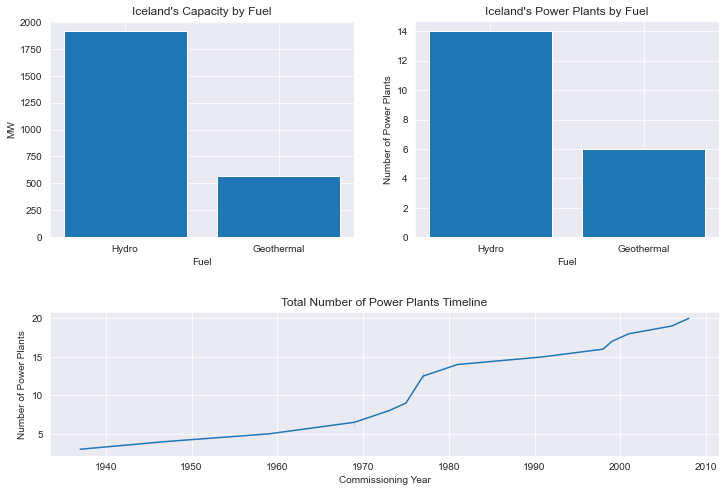

In [114]:
iceland_gpp = gpp[gpp.country_long == 'Iceland']
xlabels = ['Hydro','Geothermal']
iceland_capacity = [iceland_gpp.capacity_mw[iceland_gpp.primary_fuel == 'Hydro'].sum(),\
    iceland_gpp.capacity_mw[iceland_gpp.primary_fuel == 'Geothermal'].sum()]
iceland_pp_count = [iceland_gpp.primary_fuel[iceland_gpp.primary_fuel == 'Hydro'].count(),\
    iceland_gpp.primary_fuel[iceland_gpp.primary_fuel == 'Geothermal'].count()]

plt.figure(figsize=(12,8))
ax1 = plt.subplot(2,2,1)
plt.bar(x=xlabels, height=iceland_capacity)
plt.title('Iceland\'s Capacity by Fuel')
plt.xlabel('Fuel')
plt.ylabel('MW')

ax2=plt.subplot(2,2,2)
plt.bar(x=xlabels, height=iceland_pp_count)
plt.title('Iceland\'s Power Plants by Fuel')
plt.xlabel('Fuel')
plt.ylabel('Number of Power Plants')

iceland_trend = iceland_gpp.groupby(by=['primary_fuel','commissioning_year'])\
    .country_long.count().reset_index()\
    .sort_values(by='commissioning_year', ascending=True, ignore_index=True)
iceland_trend.columns = ['primary_fuel','commissioning_year','count_pp']

iceland_commissioned = iceland_trend.count_pp
iceland_total = []
count = 2
for i in range(len(iceland_trend)):
    count += iceland_commissioned[i]
    iceland_total.append(count)

iceland_trend['total'] = iceland_total
ax3 = plt.subplot(3,1,3)
sns.lineplot(data=iceland_trend, x='commissioning_year', y='total', markers='o')
plt.title('Total Number of Power Plants Timeline')
plt.xlabel('Commissioning Year')
plt.ylabel('Number of Power Plants')

plt.subplots_adjust(hspace=0.01)
plt.show()

Iceland only has 2 types of power plants, Hydro and Geothermal, but most of the capacity comes from Hydro plants.

# Results
We set out to create a general survey of the current capacity of the world to produce electricity, and throughout this project we analyzed data in our attempt to create it.

We were able to determine that the world has a total capacity to generate electricity of 5.706 TW. 

When we look at how that capacity is being generated, splitting power plants by fuel type, more than 4 TW of the capacity comes from power plants using fuels that are not renewable. Of that, Coal and Gas have the largest share.

An important observation is that in the non-renewable category, Nuclear power plants only make up a small portion of the capacity, although on average being able to generate far more electricity. This might be the result of the cost of the technology, as well as concerns surrounding how safe it is.

Another important finding is that in recent years, renewables have picked up a lot and were built in much larger numbers. This points to a preference and a trend of moving away from power plants that do not generate "clean" electricity.

Even with the recent adoption of these power sources, on average they still have a considerably smaller capacity to generate electricity. It might be that the technology is lagging behind plants running on different fuels, or it might point to a shift from large centralized power grids, to smaller ones, more specialized and tailored to take advantage of the local access to resources.

When we looked at who has the most power plants, unsurprisingly the top two positions were occupied by the U.S.A. and China. Surprising however is that while the U.S.A. had far more power plants, China surpassed it in total capacity, as well as average capacity per power plant. This might suggest that the U.S.A. is dealing with an ageing infrastructure and technology when compared to China.

Another key objective of our report was to see the capacity countries are able to generate per capita. In this ranking, the top spot was taken by Iceland, which is an outlier of our dataset in many ways. One of these ways is that it only has power plants running on renewable power sources, such as Hydro and Geothermal.

In stark contrast, Bahrain has the 3rd most capacity per 1000 people, which produces it almost exclusively in Gas and Oil powered power plants. 

Overall we were able to create the overview we were after, but in order to draw more accurate conclusions based on the findings, further research in certain areas is needed.

### Further research
An important aspect when looking at countries preference for certain fuels is their access to natural resources, which can dictate how viable certain technologies are to be used in a region.

With a mindset of moving away from heavily polluting power plants, further research is needed into the relationship between a country's economy and the preference for fuels, as the technologies for each can vary a lot and associated costs can be significant.

Another area needing further research is a cost-capacity relationship analysis for each power plant type in order to identify opportunities to shift from one to the other.